### Compute the stationary distribution of the model

Proof of concept of the stationary distribution of the model. Does not make use of CompEcon code, or rely on linear basis matrices. 

Works, but still more to do. 

- Need to generalize the code to take models with any number of Markov states and state variables.

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa
import matplotlib.pyplot as plt
from dolo.algos.dtmscc.time_iteration import time_iteration
from dolo import yaml_import
from dolo import pcat

In [2]:
filename = 'incomplete_markets_dtmscc.yaml'
model = yaml_import(filename)
parms = model.calibration['parameters']
kgrid = model.get_grid().grid
egrid = np.array([[0], [1]])
Ne = model.markov_chain[0].shape[0]
Nk = model.get_grid().orders[0]
Nkf = 100
kgridf = np.linspace(0.0,100.0,num=Nkf)
# pcat(filename)

In [3]:
# Use time iteration to create decision rule and 
drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [4]:
mdrc0 = mdr(0, kgridf.reshape(-1,1))    # (i_m, points, out=None)
mdrc1 = mdr(1, kgridf.reshape(-1,1))    # (i_m, points, out=None)

In [5]:
# Note: this will not be in the correct shape initially. 
trans = model.functions['transition']      # trans(m, s, x, M, p, out)

k0 = trans(egrid[0], kgridf.reshape(-1,1), mdrc0, egrid[0], parms)
k1 = trans(egrid[1], kgridf.reshape(-1,1), mdrc1, egrid[1], parms)                                               
kprimef = np.vstack([k0, k1])

In [ ]:
# trans = model.functions['transition']      # trans(m, s, x, M, p, out)
# mdrc = np.zeros([Nkf, Ne])
# kprimef = np.zeros([Nkf, Ne])
# for i_m in range(Ne):
#     mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()
#     kprimef[:, i_m] = (trans(egrid[i_m], kgridf.reshape(-1,1), mdrc[:, i_m].reshape(-1,1), egrid[i_m], parms)).flatten()
    
# kprimef = kprimef.reshape([Nkf*Ne, 1]).flatten()

### Construct the transition matrices

In [6]:
# Lookup function
from numpy import searchsorted
def lookup(grid, x):
    '''
    Grid must be sorted in ascending order. Find the first index, i, in grid such that grid[i] <= x. 
    At the end of table, if x = grid[N], then set i = N-1. This is so that the upper index, i+1, would, be N-1. 
    '''
    N = grid.shape[0]-1   # N = last index in grid
    m = grid.min()
    M = grid.max()
    x = np.maximum(x, m)
    x = np.minimum(x, M)
    idU = searchsorted(grid, x)   # Get insertion index = index of the upper bound
    idU = np.maximum(idU, 1)      # Make sure upper bound is always the second index, 1, or higher.
    idL = idU -1                  # lower bound index = upper bound index - 1
#     idL = np.maximum(idL, 0)      
#     idL = np.minimum(idx, N-1)
    return idL, idU

    

In [41]:
P = model.markov_chain[1]
Qe = np.kron(P, np.ones([Nkf,1]))

# 
# Qk = np.zeros([Nkf*Ne, Nkf])

idxlist = np.arange(0,Nkf*Ne).reshape(-1,1)
idL, idU = lookup(kgridf, kprimef)

# IMPORTANT: we want to assign the distance away from the *lower* bound to the *upper* bound (and conversely, assign
# distance awway from *lower* bound to the *upper* bound. That is, if k' is 3/4 of the way between kj and kj+1, 
# then want to assign 3/4 weight to kj+1. 

toupper = (kprimef - kgridf[idL])/(kgridf[idU] - kgridf[idL])
tolower = (kgridf[idU] - kprimef)/(kgridf[idU] - kgridf[idL])

# #TODO: Is there a way to make the Qk matrix in one line? 
QkL = spa.coo_matrix((tolower.flatten(), (idxlist.flatten(), idL.flatten())), shape=(Nkf*Ne, Nkf))
QkU = spa.coo_matrix((toupper.flatten(), (idxlist.flatten(), idU.flatten())), shape=(Nkf*Ne, Nkf))
Qk =(QkL + QkU).tocsr()    # convert to CSR for better sparse matrix arithmatic performance.


# # TODO: NEED TO KEEP THIS AS A SPARSE MATRIX!!
Qk = Qk.toarray()
rowkron = Qe[:, :, None]*Qk[:, None, :]      
rowkron = rowkron.reshape([Nkf*Ne, -1])

QT = spa.csr_matrix(rowkron).T     
# # NOTE: CSR (Compressed Sparse Row) has efficient arithmetic operations, but inefficient column slicing. 
# # Useful here since we are just using QT for transitions.

L = np.ones(Nkf*Ne)
L = L/sum(L)
itmaxL = 5000
tolL = 1e-11
verbose = False

for itL in range(itmaxL):
    Lnew = QT*L      # Sparse matrices can be multipled
    dL = np.linalg.norm(Lnew-L)/np.linalg.norm(L)
    if (dL < tolL):
        break

    if verbose is True:
        if np.mod(itL, 100) == 0:
            print('Iteration = %i, dist = %f \n' % (itL, dL))

    L = np.copy(Lnew)
    
L = L.reshape(Ne, Nkf).T

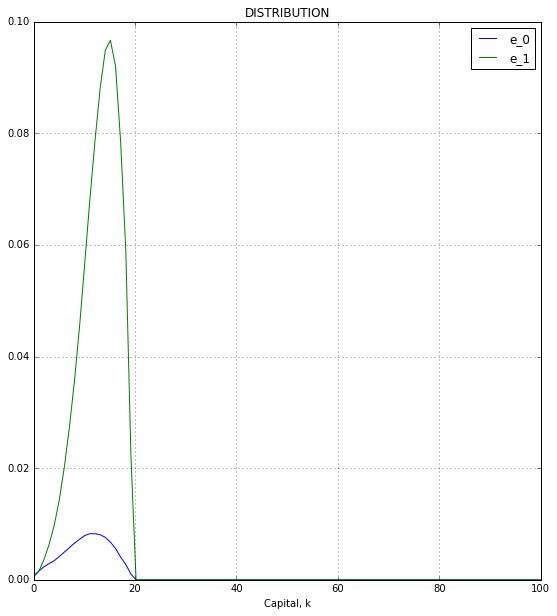

In [44]:
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, L[:,0],label='e_0')
plt.plot(kgridf, L[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

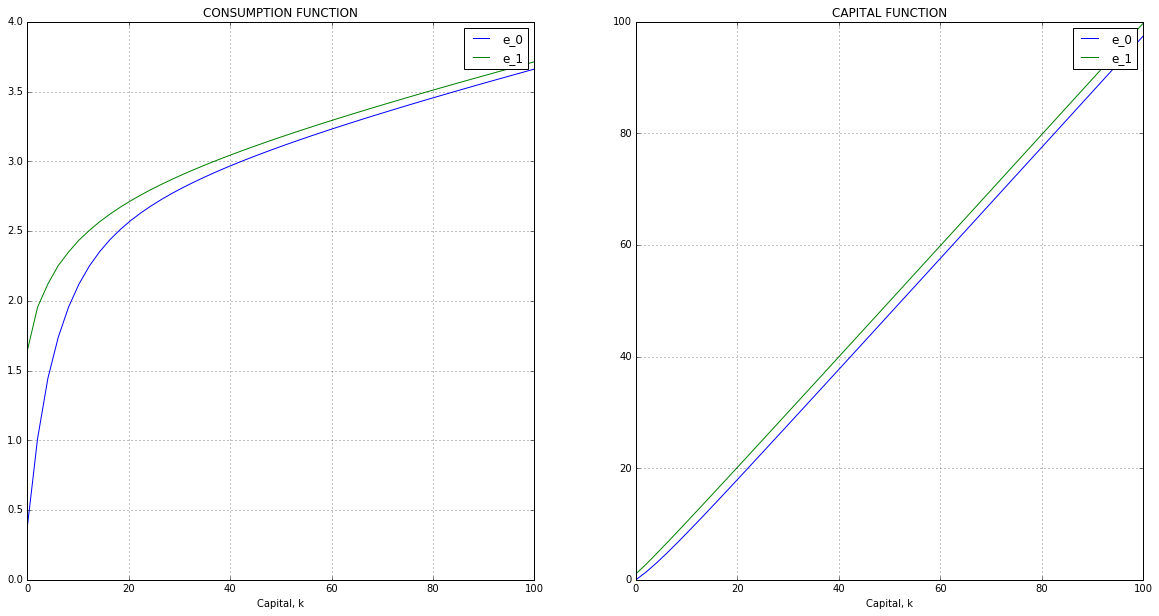

In [111]:
# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgrid, drc[0,:],label='e_0')
plt.plot(kgrid, drc[1,:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgrid, kprime0,label='e_0')
plt.plot(kgrid, kprime1,label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 